In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext watermark
%watermark

Last updated: 2022-08-31T22:27:41.867088+04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 7.34.0

Compiler    : GCC 12.1.1 20220507 (Red Hat 12.1.1-1)
OS          : Linux
Release     : 5.19.4-200.fc36.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
import geopandas
from libpysal import examples
import matplotlib
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pulp
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

numpy              : 1.22.4
spaghetti          : 1.6.6
matplotlib_scalebar: 0.8.1
sys                : 3.10.6 (main, Aug  2 2022, 00:00:00) [GCC 12.1.1 20220507 (Red Hat 12.1.1-1)]
libpysal           : 4.6.2
pulp               : 2.6.0
matplotlib         : 3.5.3
geopandas          : 0.11.1



/home/mrov/.local/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [4]:
class MTZ_TSP:
    def __init__(self, nodes, cij, xij_tag="x_%s,%s", ui_tag="u_%s", display=True):
        self.nodes, self.cij = nodes, cij
       
        self.p = self.nodes.shape[0]
        
        self.rp_0n, self.rp_1n = range(self.p), range(1, self.p)
        
        self.id = self.nodes.name
        
        self.xij_tag, self.ui_tag = xij_tag, ui_tag

        
        self.tsp = pulp.LpProblem("MTZ_TSP", pulp.LpMinimize)
        
        self.tour_dvs()
        
        self.arn_dvs()
        
        self.objective_func()
        
        self.entry_exit_constrs(entry=True)
        
        self.entry_exit_constrs(entry=False)
        
        self.prevent_subtours()
      
        self.tsp.solve(pulp.PULP_CBC_CMD(msg=False))

        self.get_decisions(display=display)
       
        self.construct_tour()

    def tour_dvs(self):
        

            def _name(_x):
            
                return self.nodes[_x].split("_")[-1]

            xij = numpy.array(
            [
                [
                    pulp.LpVariable(self.xij_tag % (_name(i), _name(j)), cat="Binary")
                    for j in self.rp_0n
                ]
                for i in self.rp_0n
            ]
        )

            self.xij = xij

    def arn_dvs(self):
        
            ui = numpy.array(
                [pulp.LpVariable(self.ui_tag % (i), lowBound=0) for i in self.rp_0n]
            )

            self.ui = ui

    def objective_func(self):
        
            self.tsp += pulp.lpSum(
            [
                self.cij[i, j] * self.xij[i, j]
                for i in self.rp_0n
                for j in self.rp_0n
                if i != j
            ]
        )

    def entry_exit_constrs(self, entry=True):
        
            if entry:
                for i in self.rp_0n:
                    self.tsp += (
                    pulp.lpSum([self.xij[i, j] for j in self.rp_0n if i != j]) == 1
                    )
        
            else:
                for j in self.rp_0n:
                    self.tsp += (
                    pulp.lpSum([self.xij[i, j] for i in self.rp_0n if i != j]) == 1
                )

    def prevent_subtours(self):
        
            for i in self.rp_1n:
                for j in self.rp_1n:
                    if i != j:
                        self.tsp += (
                            self.ui[i] - self.ui[j] + self.p * self.xij[i, j] <= self.p - 1
                    )

    def get_decisions(self, display=True):
       
            cycle_ods = {}
            for var in self.tsp.variables():
                if var.name.startswith(self.ui_tag[0]):
                    continue
                if var.varValue > 0:
                    if display:
                        print("%s: %s" % (var.name, var.varValue))
                    od = var.name.split("_")[-1]
                    o, d = [int(tf) for tf in od.split(",")]
                    cycle_ods[o] = d
            if display:
                print("Status: %s" % pulp.LpStatus[self.tsp.status])

            self.cycle_ods = cycle_ods

    def construct_tour(self):
        
            tour_pairs = []
            for origin in self.rp_0n:
                tour_pairs.append([])
                try:
                    tour_pairs[origin].append(next_origin)
                    next_origin = self.cycle_ods[next_origin]
                    tour_pairs[origin].append(next_origin)
                except NameError:
                    next_origin = self.cycle_ods[origin]
                    tour_pairs[origin].append(origin)
                    tour_pairs[origin].append(next_origin)

            tour_pairs = {idx: sorted(tp) for idx, tp in enumerate(tour_pairs)}
            self.tour_pairs = tour_pairs

    def extract_tour(self, paths, id_col, leg_label="leg"):

            paths[leg_label] = int
       
            for leg, tp in self.tour_pairs.items():
                paths.loc[paths[id_col] == tuple(tp), leg_label] = leg

        
            tour = paths[paths[leg_label] != int].copy()
            tour.sort_values(by=[leg_label], inplace=True)
            tour[leg_label] = tour[leg_label].astype(int)

            return tour


In [5]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "esri:102649"
streets = streets.to_crs("epsg:2762")
streets.head()

,ID,Length,geometry
0,1.0,244.116229,"LINESTRING (222008.039 267347.937, 222008.067 ..."
1,2.0,375.974828,"LINESTRING (222007.859 267549.106, 222008.039 ..."
2,3.0,400.353405,"LINESTRING (221421.335 267804.115, 221412.310 ..."
3,4.0,660.000000,"LINESTRING (220876.024 268352.613, 220804.856 ..."
4,5.0,660.000000,"LINESTRING (220803.334 268398.049, 220917.907 ..."


In [6]:
all_crimes = geopandas.read_file(examples.get_path("crimes.shp"))
all_crimes.crs = "esri:102649"
all_crimes = all_crimes.to_crs("epsg:2762")
all_crimes.head()



,POLYID2,POLYID,geometry
0,1,1,POINT (221869.340 266919.724)
1,2,2,POINT (220924.154 266932.526)
2,3,3,POINT (221710.234 266959.958)
3,4,4,POINT (221901.040 266961.482)
4,5,5,POINT (221751.078 266962.092)


In [7]:
numpy.random.seed(1960)
koenigsberg_cases = 7 * 2
subset_idx = numpy.random.choice(all_crimes.index, koenigsberg_cases, replace=False)
crimes_scenes = all_crimes[all_crimes.index.isin(subset_idx)].copy()
crimes_scenes

,POLYID2,POLYID,geometry
5,6,6,POINT (221653.237 266962.396)
11,12,12,POINT (220776.021 266967.578)
48,49,49,POINT (220963.473 267280.608)
62,63,63,POINT (220773.887 267386.374)
88,89,89,POINT (220798.271 267545.785)
114,115,115,POINT (221502.360 267697.880)
120,121,121,POINT (220475.487 267730.494)
132,133,133,POINT (221678.840 267761.279)
169,170,170,POINT (221155.497 267919.775)
184,185,185,POINT (221854.405 268049.010)


In [8]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices.head()

,id,geometry,comp_label
0,0,POINT (222008.039 267347.937),0
1,1,POINT (222008.067 267316.658),0
2,2,POINT (222007.859 267549.106),0
3,3,POINT (221421.335 267804.115),0
4,4,POINT (221412.310 267921.219),0


In [9]:
arcs.head()

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (222008.039 267347.937, 222008.067 ...",0
1,"(0, 2)","LINESTRING (222008.039 267347.937, 222007.859 ...",0
2,"(1, 110)","LINESTRING (222008.067 267316.658, 222082.474 ...",0
3,"(1, 127)","LINESTRING (222008.067 267316.658, 221806.899 ...",0
4,"(1, 213)","LINESTRING (222008.067 267316.658, 222008.247 ...",0


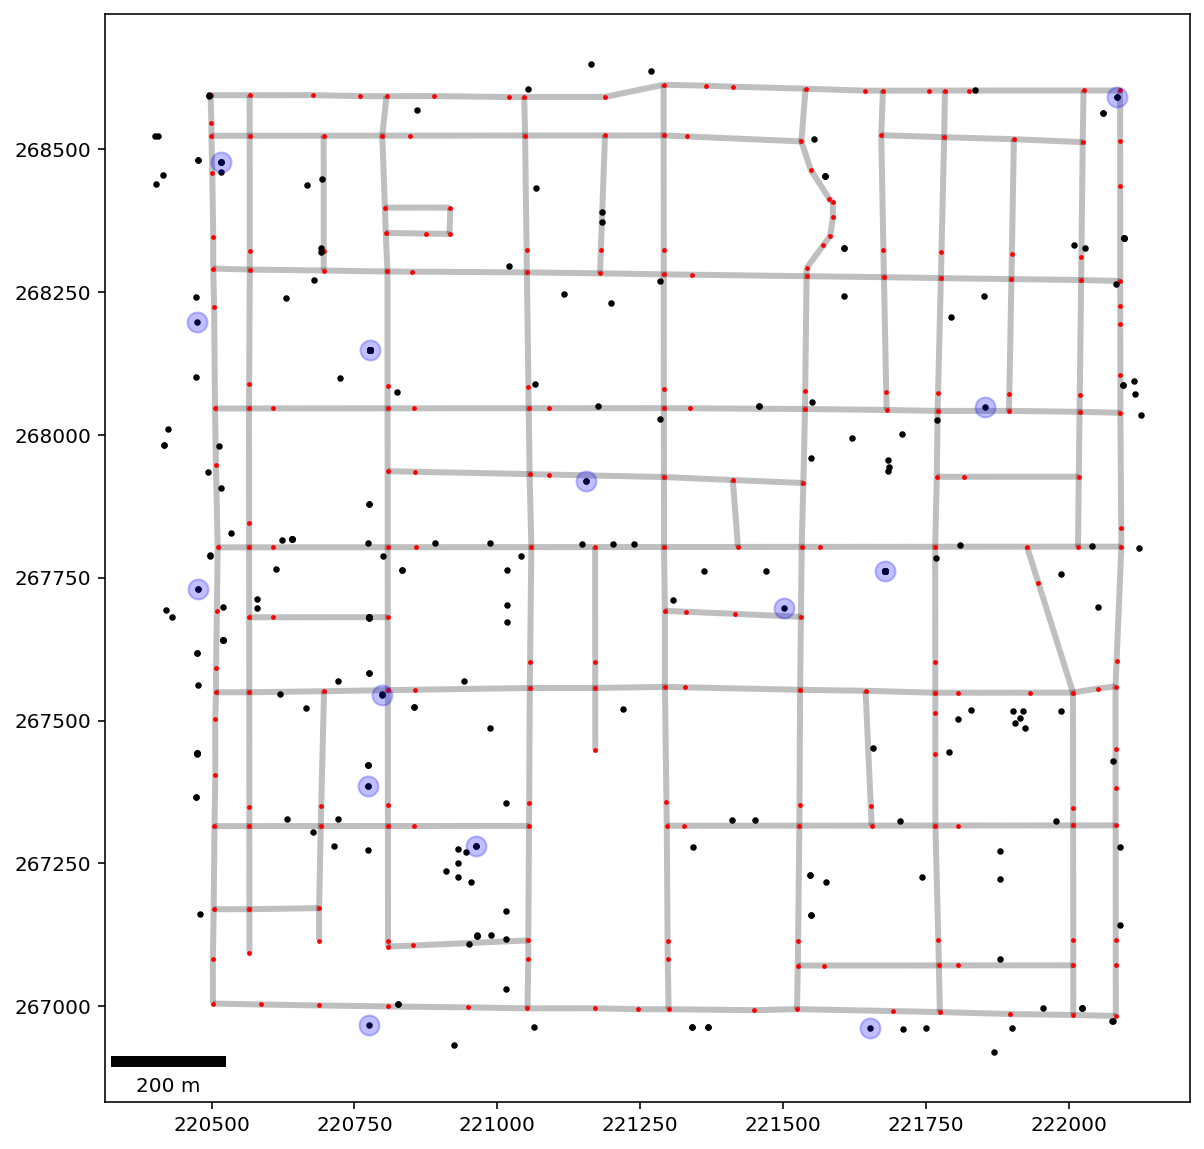

In [10]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
all_crimes.plot(ax=base, markersize=5, color="k", zorder=2)
crimes_scenes.plot(ax=base, markersize=100, alpha=0.25, color="blue", zorder=2)
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

In [11]:
ntw.snapobservations(crimes_scenes, "crime_scenes")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes", snapped=True)
pp_obs_snapped

,id,geometry,comp_label
0,0,POINT (221653.845 266992.454),0
1,1,POINT (220776.477 267000.267),0
2,2,POINT (220963.445 267315.781),0
3,3,POINT (220808.576 267386.401),0
4,4,POINT (220798.147 267553.260),0
5,5,POINT (221501.696 267683.117),0
6,6,POINT (220509.721 267730.063),0
7,7,POINT (221678.803 267804.333),0
8,8,POINT (221155.708 267929.413),0
9,9,POINT (221854.411 268042.257),0


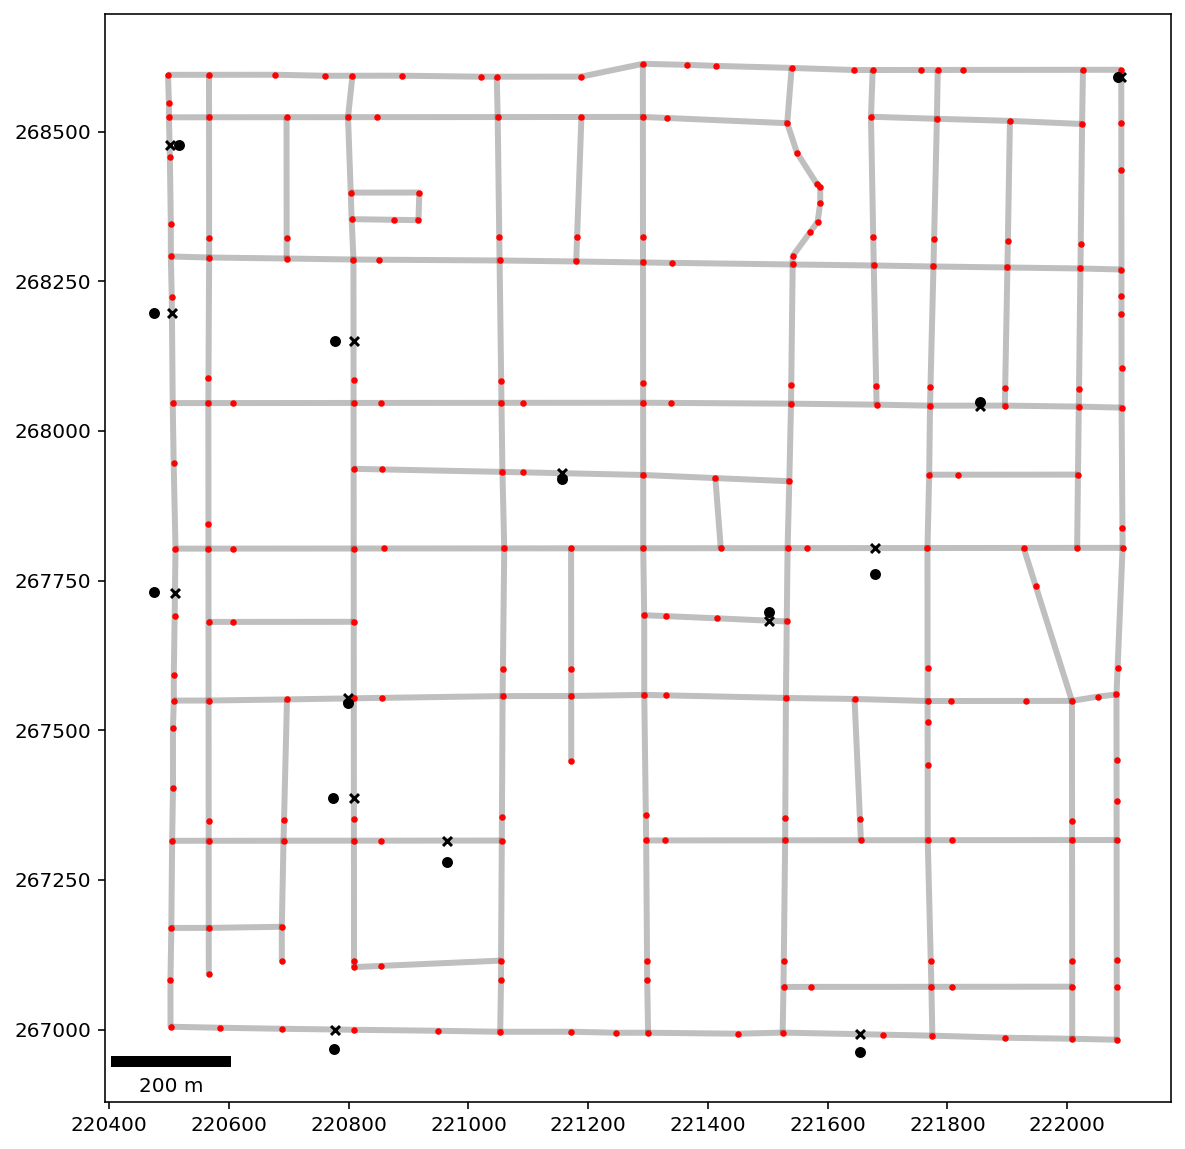

In [12]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=20, marker="x", color="k", zorder=2)
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

In [13]:
d2d_dist, tree = ntw.allneighbordistances("crime_scenes", gen_tree=True)
d2d_dist[:3, :3]

array([[          nan,  877.47328978, 1012.61273924],
       [ 877.47328978,           nan,  688.11614166],
       [1012.61273924,  688.11614166,           nan]])

In [14]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 1), (164, 158)),
  ((0, 2), (164, 142)),
  ((0, 3), (164, 197)),
  ((0, 4), (164, 147))],
 [((10, 13), (72, 98)),
  ((11, 12), (26, 29)),
  ((11, 13), (26, 85)),
  ((12, 13), (30, 85))])

In [15]:
#The TSP
pp_obs["dv"] = pp_obs["id"].apply(lambda _id: "x_%s" % _id)
pp_obs

,id,geometry,comp_label,dv
0,0,POINT (221653.237 266962.396),0,x_0
1,1,POINT (220776.021 266967.578),0,x_1
2,2,POINT (220963.473 267280.608),0,x_2
3,3,POINT (220773.887 267386.374),0,x_3
4,4,POINT (220798.271 267545.785),0,x_4
5,5,POINT (221502.360 267697.880),0,x_5
6,6,POINT (220475.487 267730.494),0,x_6
7,7,POINT (221678.840 267761.279),0,x_7
8,8,POINT (221155.497 267919.775),0,x_8
9,9,POINT (221854.405 268049.010),0,x_9


In [16]:
mtz = MTZ_TSP(pp_obs["dv"],d2d_dist)

x_0,1: 1.0
x_1,2: 1.0
x_10,8: 1.0
x_11,12: 1.0
x_12,10: 1.0
x_13,7: 1.0
x_2,3: 1.0
x_3,4: 1.0
x_4,6: 1.0
x_5,0: 1.0
x_6,11: 1.0
x_7,5: 1.0
x_8,9: 1.0
x_9,13: 1.0
Status: Optimal


In [17]:
paths = ntw.shortest_paths(tree, "crime_scenes")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,geometry,O,D,id
0,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,1,"(0, 1)"
1,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,2,"(0, 2)"
2,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,3,"(0, 3)"
3,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,4,"(0, 4)"
4,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,5,"(0, 5)"


In [18]:
tour = mtz.extract_tour(paths_gdf.copy(), "id")
tour.head()

,geometry,O,D,id,leg
0,"LINESTRING (221653.845 266992.454, 221524.694 ...",0,1,"(0, 1)",0
13,"LINESTRING (220776.477 267000.267, 220808.874 ...",1,2,"(1, 2)",1
25,"LINESTRING (220963.445 267315.781, 220854.493 ...",2,3,"(2, 3)",2
36,"LINESTRING (220808.576 267386.401, 220808.448 ...",3,4,"(3, 4)",3
47,"LINESTRING (220798.147 267553.260, 220696.842 ...",4,6,"(4, 6)",4


In [19]:
def tour_labels(t, b):
    

    def _lab_loc(_x):
        
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]

    kws = {"size": 20, "ha": "center", "va": "bottom", "weight": "bold"}
    t.apply(lambda x: b.annotate(text=x.leg, xy=_lab_loc(x), **kws), axis=1)


def obs_labels(o, b):
    

    def _lab_loc(_x):
        
        return _x.geometry.coords[0]

    kws = {"size": 14, "ha": "left", "va": "bottom", "style": "oblique", "color": "k"}
    o.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

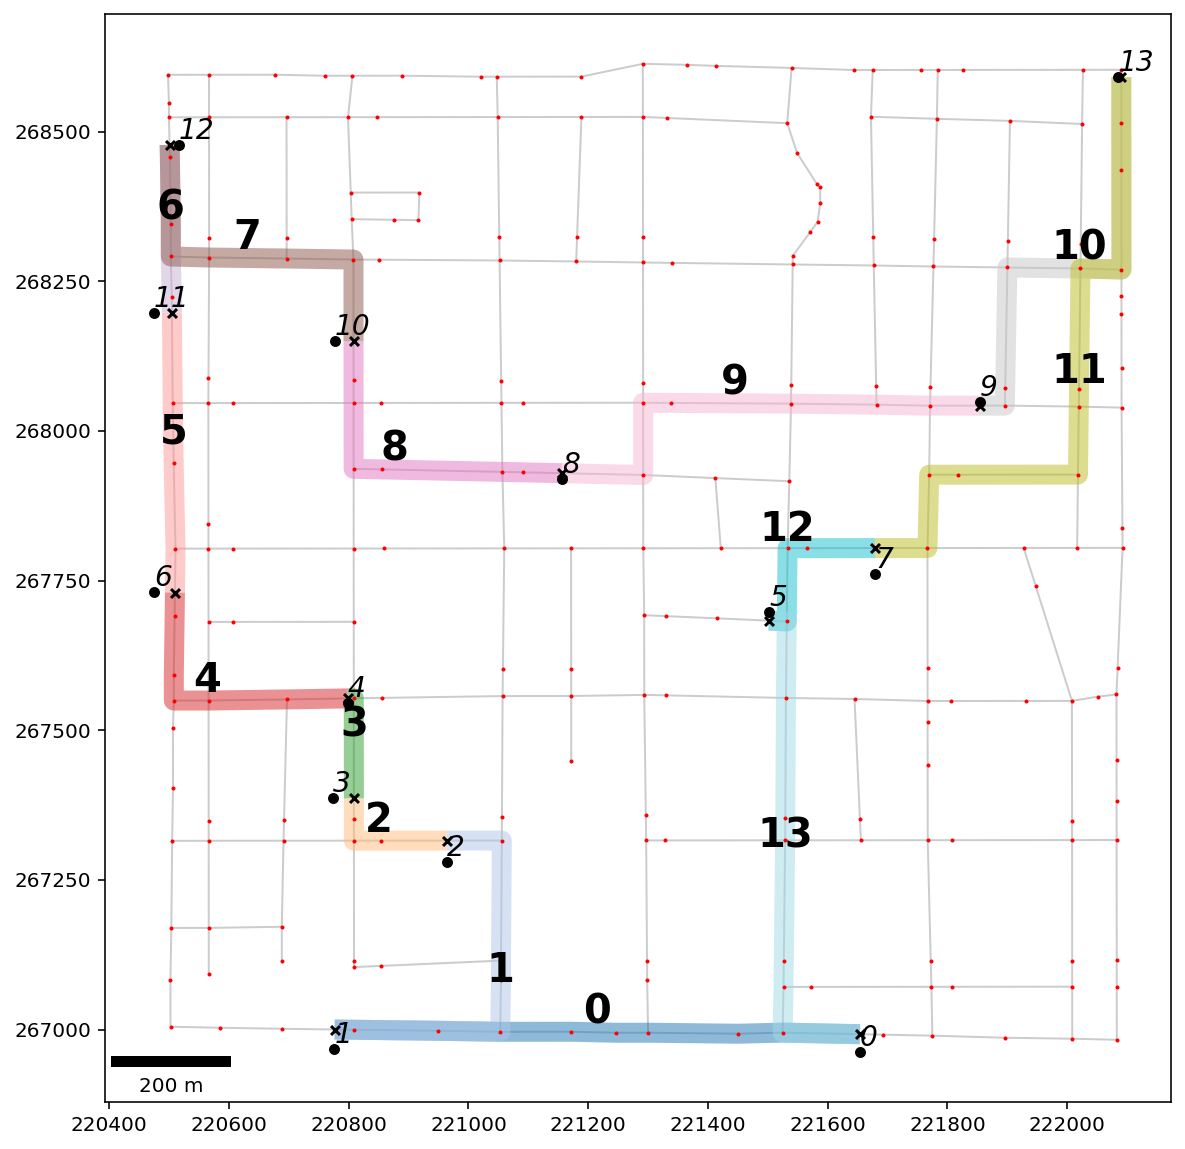

In [20]:
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
tour.plot(ax=base, column="leg", cmap="tab20", alpha=0.50, linewidth=10, zorder=1)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=3)
pp_obs_snapped.plot(ax=base, markersize=20, color="k", marker="x", zorder=2)


tour_labels(tour, base)

obs_labels(pp_obs, base)

scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);